In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
data = pd.read_csv('MSFT.csv')
data_tensor = torch.tensor(data.to_numpy()[:,1:5].astype(float))
data_tensor

tensor([[8.8542e-02, 1.0156e-01, 8.8542e-02, 9.7222e-02],
        [9.7222e-02, 1.0243e-01, 9.7222e-02, 1.0069e-01],
        [1.0069e-01, 1.0330e-01, 1.0069e-01, 1.0243e-01],
        ...,
        [2.8890e+02, 2.8925e+02, 2.8556e+02, 2.8615e+02],
        [2.8208e+02, 2.8246e+02, 2.7722e+02, 2.7775e+02],
        [2.7644e+02, 2.7886e+02, 2.7540e+02, 2.7644e+02]], dtype=torch.float64)

In [7]:
def train_loop_conv(train_x,train_y,val_x,val_y,model,optimizer, loss_fn,n_epoch=5000):
    start = time.time()
    step = int(n_epoch/10)
    t_loss = []
    v_loss = []
    for i in range(n_epoch):
        train_y_p = model(train_x)
        train_loss = loss_fn(train_y_p,train_y)
        t_loss.append(train_loss.item())

        val_y_p = model(val_x)
        val_loss = loss_fn(val_y_p,val_y)
        v_loss.append(val_loss.item())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if i % step == 0:
            print('Epoch: %d, Training-Loss: %f, Validation-Loss: %f' % (i,train_loss,val_loss))

    end = time.time()
    print('------------------------------')
    print('training loop finished. ')
    print(f'training time: {end-start}')
    print('Training-Loss: %f, Validation-Loss: %f' % (train_loss,val_loss))

    return t_loss,v_loss

def get_train_data(data,label_col_idx,size=5):
    n_samples =int(data.shape[0] / size) + (data.shape[0] % size)
    n_channels = data.shape[1]
    X_ = torch.zeros((n_samples,n_channels,size))
    y_ = torch.zeros(n_samples)
    for i in range(n_samples):
        for j in range(n_channels):
            X_[i,j] = data[i:i+size,j]
        y_[i] = data[i+size,label_col_idx]
    return X_ , y_


In [8]:
conv_model_norm = nn.Sequential(
    nn.Conv1d(4,128,3,padding=1),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(128,128,5,padding=2),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Flatten(),
    nn.Linear(256,1)
)

loss_L1 = nn.L1Loss()

In [9]:
data_min = data_tensor.min(dim=0)[0]
data_max = data_tensor.max(dim=0)[0]
data_mean = data_tensor.mean(dim=0,keepdim=True)
data_std = data_tensor.std(dim=0)
data_normalized = (data_tensor - data_min) / (data_max - data_min)
data_standardized = (data_tensor - data_mean) / data_std

X, y = get_train_data(data_normalized,3,10)
input_data = X
input_labels = y.unsqueeze(dim=1)

n_samples = X.shape[0]
n_val = int (0.2 * n_samples)

shuffeled_indices = torch.randperm(n_samples)

train_indices = shuffeled_indices[:-n_val]
val_indices = shuffeled_indices[-n_val:]

optimizer = optim.Adam(conv_model_norm.parameters(),lr=1e-3)
t_loss, v_loss = train_loop_conv(input_data[train_indices],input_labels[train_indices],input_data[val_indices],input_labels[val_indices], conv_model_norm, optimizer, loss_L1, n_epoch=5000)

Epoch: 0, Training-Loss: 0.000730, Validation-Loss: 0.000712
Epoch: 500, Training-Loss: 0.000389, Validation-Loss: 0.000376
Epoch: 1000, Training-Loss: 0.000139, Validation-Loss: 0.000130
Epoch: 1500, Training-Loss: 0.000465, Validation-Loss: 0.000477
Epoch: 2000, Training-Loss: 0.000114, Validation-Loss: 0.000105
Epoch: 2500, Training-Loss: 0.000094, Validation-Loss: 0.000097
Epoch: 3000, Training-Loss: 0.000231, Validation-Loss: 0.000219
Epoch: 3500, Training-Loss: 0.000120, Validation-Loss: 0.000123
Epoch: 4000, Training-Loss: 0.000068, Validation-Loss: 0.000060
Epoch: 4500, Training-Loss: 0.000069, Validation-Loss: 0.000060
------------------------------
training loop finished. 
training time: 145.36720204353333
Training-Loss: 0.000061, Validation-Loss: 0.000060


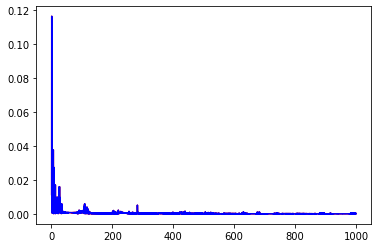

In [6]:
plt.plot(np.linspace(1,1000,num=5000),t_loss,'r')
plt.plot(np.linspace(1,1000,num=5000),v_loss,'b')